In [1]:
import itertools 
import math 
import os 
import fresnel 
import freud
import hoomd
import numpy 
import warnings
import gsd.hoomd
import IPython
import PIL
import fresnel.material
import packaging.version 
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_2d(snapshot):

    L = snapshot.configuration.box[0]
    
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Sphere(scene, N=len(snapshot.particles.position), radius=0.5)
    
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    
    positions_array = numpy.array(snapshot.particles.position)
    geometry.position[:, :2] = positions_array[:, :2]  
    geometry.outline_width = 0.04 
    
    fresnel.geometry.Box(scene, [L, L, 0], box_radius=0.02) 
    
    scene.camera = fresnel.camera.Orthographic.fit(scene)
    
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

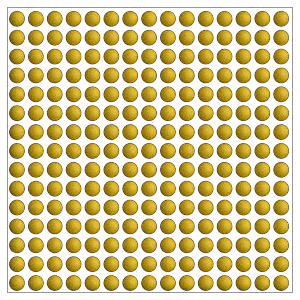

In [3]:
m = 15
N_particles = m ** 2
spacing = 1.2
K = math.ceil(N_particles ** (1/2))
L = K * spacing 
x = numpy.linspace(-L / 2 + spacing / 2, L / 1.9, K, endpoint=False)

position = list(itertools.product(x, x))

frame = gsd.hoomd.Frame()
frame.particles.N = len(position)  
frame.particles.position = numpy.hstack([numpy.array(position[0:N_particles]), numpy.zeros((N_particles, 1))])  
frame.particles.typeid = [0] * N_particles 
frame.configuration.box = [L, L, 0]

render_2d(frame)

In [17]:
print(L) 

18.0


In [18]:
if box.is2D:
    pass

NameError: name 'box' is not defined

In [4]:
print(N_particles)

225


In [10]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)

mc = hoomd.hpmc.integrate.Sphere()
mc.shape['disks'] = dict(diameter=1)

simulation.operations.integrator = mc


In [11]:
simulation.run(1)

RuntimeError: Cannot run before state is set.

In [12]:
fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

frame = gsd.hoomd.Frame()
frame.particles.N = len(position)
# Ensure positions are in 3D (x, y, z) by appending zero z-coordinates
positions_2d = numpy.array(position[0:N_particles])  # 2D positions (x, y)
positions_3d = numpy.hstack([positions_2d, numpy.zeros((N_particles, 1))])  # Add z = 0 for each particle

frame.particles.position = positions_3d  # Assign to particle positions

frame.particles.typeid = [0] * N_particles
frame.particles.types = ['disks']
frame.configuration.box = [L, L, 0.01, 0, 0, 0]
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)


In [13]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)

mc = hoomd.hpmc.integrate.Sphere()

simulation.operations.integrator = mc
simulation.create_state_from_gsd(filename='lattice.gsd')

mc.shape['disks'] = dict(diameter=1)

In [14]:
initial_snapshot = simulation.state.get_snapshot()

In [15]:
simulation.run(1)

*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Exceeded sanity limit for image list, generated out to 31 lattice vectors. Logic error?
This message will not be repeated.
*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 567 images per trial move, performance may slow.
This message will not be repeated.


In [16]:
mc.overlaps

13950

In [27]:
mc.translate_moves

(9000000, 0)

In [28]:
mc.translate_moves[0] / sum(mc.translate_moves)

1.0

In [29]:
mc.rotate_moves

(0, 0)

In [30]:
mc.overlaps

0

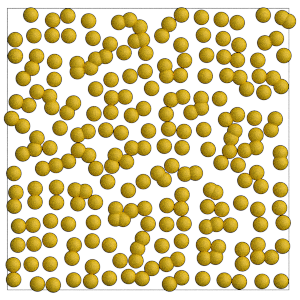

In [31]:
final_snapshot = simulation.state.get_snapshot()
render_2d(final_snapshot)

In [32]:
initial_snapshot.particles.position[0:4]

array([[-8.39999962, -8.39999962,  0.        ],
       [-8.39999962, -7.20842123,  0.        ],
       [-8.39999962, -6.01684189,  0.        ],
       [-8.39999962, -4.82526302,  0.        ]])

In [33]:
final_snapshot.particles.position[0:4]

array([[-8.59864586e+00, -8.34223307e+00,  2.13954682e-03],
       [-8.62425868e+00, -7.39749875e+00, -4.35259593e-03],
       [-8.32883025e+00, -6.13891119e+00, -4.20861271e-03],
       [-8.28083115e+00, -4.92331095e+00, -3.96043800e-03]])

In [34]:
fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"

hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='random.gsd')



In [8]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='random.gsd')

In [9]:
a = 0.01 / 2
A_particle = math.pi * a**2
initial_area_fraction = (N_particles * A_particle) / simulation.state.box.volume
print(f"Initial area fraction: {initial_area_fraction}")

Initial area fraction: 0.005454154034392123


In [15]:
mc = hoomd.hpmc.integrate.Sphere()
mc.shape["disks"] = dict(diameter=0.1)
simulation.operations.integrator = mc

In [16]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.3
final_box.volume = simulation.state.N_particles * A_particle / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box
)

In [17]:
simulation.operations.updaters.append(compress)

In [21]:
periodic = hoomd.trigger.Periodic(100)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    trigger=periodic,
    max_translation_move=0.01,
)
simulation.operations.tuners.append(tune)

In [22]:
simulation.run(100)

In [23]:
simulation.run(10000)

*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.0025 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to

In [24]:
mc.d['disks']

0.0024999999441206455

In [25]:
mc.overlaps

4500

In [46]:
final_area_fraction = (simulation.state.N_particles * A_particle) / simulation.state.box.volume
print(f"Final area fraction: {final_area_fraction}")


Final area fraction: 0.57


In [27]:
if not compress.complete:
    message = 'Compression failed to complete'
    raise RuntimeError(message)

RuntimeError: Compression failed to complete

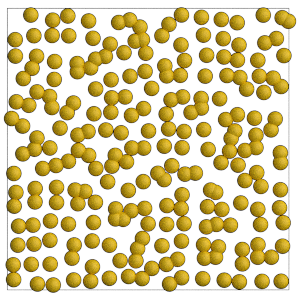

In [26]:
render_2d(simulation.state.get_snapshot())

In [49]:
fn = os.path.join(os.getcwd(), 'compressed.gsd')
![ -e "$fn" ] && rm "$fn"

hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='compressed.gsd')

In [50]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
mc = hoomd.hpmc.integrate.Sphere()
simulation.operations.integrator = mc

In [51]:
simulation.create_state_from_gsd(filename='compressed.gsd')

In [52]:
fn = os.path.join(os.getcwd(), 'trajectory.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [53]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [55]:
simulation.run(100)

*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 29 images per trial move, performance may slow.
This message will not be repeated.


In [56]:
simulation.run(5000)

*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move distance or nselect too big, reducing move distance to 0.000530751 for type disks
*Warning*: Move dist

In [57]:
simulation.run(100)

In [58]:
translate_moves = mc.translate_moves
mc.translate_moves[0] / sum(mc.translate_moves)

1.0

In [59]:
simulation.run(1e5)

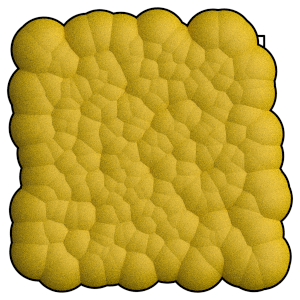

In [60]:
render_2d(simulation.state.get_snapshot())

In [61]:
gsd_writer.flush()

In [62]:
def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render_2d(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render_2d(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [63]:
traj = gsd.hoomd.open('trajectory.gsd')

In [64]:
len(traj)

105

In [85]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=14),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

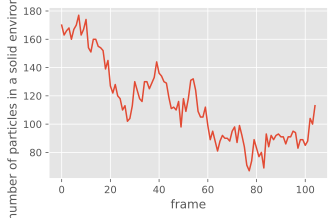

In [86]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

In [19]:
from sympy import symbols, sin, integrate

# Define variables
x, y = symbols('x y')

# Define the integrand
integrand = x**2 * (sin(y))**9

# Perform the inner integral over y (bounds: -x^2 to x^2)
inner_integral = integrate(integrand, (y, -x**2, x**2))

# Perform the outer integral over x (bounds: -1 to 1)
outer_integral = integrate(inner_integral, (x, -1, 1))
outer_integral.simplify()

ModuleNotFoundError: No module named 'sympy'